In [1]:
from datasets import load_dataset, concatenate_datasets

cmu = load_dataset('CLAPv2/CMU_Arctic')
cmu = concatenate_datasets([*cmu.values()])
display(cmu)
print(f"\n{'-' * 50}\n")
display(cmu[0])

Resolving data files:   0%|          | 0/119 [00:00<?, ?it/s]

Dataset({
    features: ['index', 'datasetname', 'audio', 'audio_len', 'text', 'raw_text'],
    num_rows: 13192
})


--------------------------------------------------



{'index': './train/10005',
 'datasetname': 'FSD50K',
 'audio': <datasets.features._torchcodec.AudioDecoder at 0x7fd190e678c0>,
 'audio_len': 3.17006254196167,
 'text': 'A man reads out "He was fond of quoting a fragment from a certain poem." in the Scottish accent',
 'raw_text': ['Title: CMU_Arctic',
  'Description: The databases consist of around 1150 utterances carefully selected from out-of-copyright texts from Project Gutenberg. The databses include US English male (bdl) and female (slt) speakers (both experinced voice talent) as well as other accented speakers.',
  'License: BSD',
  'Text: He was fond of quoting a fragment from a certain poem.',
  'Accent: Scottish',
  'Gender: male',
  'Filename: cmu_sc_male/arctic_a0520.wav']}

In [2]:
import re

def get_metadata(record):
    info     = '\n'.join(record['raw_text'])
    patterns = { 
        'speaker'    : r'Filename:\s*([^/]+)',
        'accent'     : r'Accent:\s*([^\n]+)', 
        'sex'        : r'Gender:\s*([^\n]+)',
        'spoken_text': r'Text:\s*([^\n]+)',
    }
    extract_pattern = lambda pattern: re.search(pattern, info).group(1).strip()
    metadata = { 
        key: extract_pattern(patterns[key]) for key in patterns
    }
    return metadata

def get_audio(record):
    audio = record['audio'].get_all_samples()
    samples = audio.data.mean(0)
    samplerate = audio.sample_rate
    return samples, samplerate

def get_audio_attrs(record):
    metadata            = get_metadata(record)
    dataset, samplerate = get_audio(record)
    return metadata, dataset, samplerate

In [3]:
metadata, dataset, samplerates = zip(*map(get_audio_attrs, cmu))

In [4]:
from typing import final

unique_samplerates = list(set(samplerates))
assert len(unique_samplerates) == 1, "When executing this check all the audios should've been already subsampled/supersampled to the same sampling rate."

SAMPLERATE: final = unique_samplerates[0]

In [5]:
import torch
import torchaudio

WIN_MS, HOP_MS   = 15, 5
WIN_LEN, HOP_LEN = map(lambda time_ms: time_ms * SAMPLERATE // 1000, [WIN_MS, HOP_MS])

Spectrogram = torchaudio.transforms.Spectrogram(
    WIN_LEN, WIN_LEN, HOP_LEN, 
    0, torch.hann_window, None,
)

InvSpectrogram = torchaudio.transforms.InverseSpectrogram(
    WIN_LEN, WIN_LEN, HOP_LEN, 
    0, torch.hann_window,
)

def compute_PdB_t(A_ft):
    assert 1 < A_ft.ndim < 4, '`A_ft` MUST be 2D in case it does not have a batch dimension.'
    f_axis = 0 if A_ft.ndim < 3 else 1
    return 10 * torch.log10(torch.square(A_ft).sum(f_axis) + 1e-6)

def apply_vad(samples, dB_thd=-3):
    global Spectrogram, InvSpectrogram
    X_ft         = Spectrogram(samples)
    A_ft, phi_ft = map(lambda func: func(X_ft), [torch.abs, torch.angle])
    PdB_t        = compute_PdB_t(A_ft)
    f_bins       = A_ft.shape[0]
    vad_ft       = (PdB_t >= dB_thd).unsqueeze(0).expand(f_bins, -1)
    A_ft, phi_ft = map(lambda M_ft: M_ft[vad_ft].reshape(f_bins, -1), [A_ft, phi_ft])
    X_ft         = A_ft * torch.exp(1j * phi_ft)
    samples      = InvSpectrogram(X_ft)
    return samples

In [6]:
dataset = tuple(map(apply_vad, dataset))
MAX_SAMPLES: final = max(map(len, dataset))

In [7]:
from collections import defaultdict
import re

def get_audio_groups(metadata, dataset):
    
    key_components = ['accent', 'spoken_text']
    
    audio_groups = defaultdict(list)
    for idx, audio in enumerate(metadata):
        key = tuple(audio[x] for x in key_components)
        audio_groups[key].append(idx)
    
    accents, spoken_texts = map(set, zip(*audio_groups.keys()))
    
    print(f'''
    Original Recordings:
    
    Total Number of Recordings:      {len(cmu)}
    Number of Accents:               {len(accents)}
    Number of Spoken Texts:          {len(spoken_texts)}
    Number of Accented Spoken Texts: {len(audio_groups)}
    ''')

    return audio_groups

audio_groups = get_audio_groups(metadata, dataset)


    Original Recordings:

    Total Number of Recordings:      13192
    Number of Accents:               5
    Number of Spoken Texts:          1248
    Number of Accented Spoken Texts: 5181
    


In [8]:
def get_matching_pairs(metadata, dataset, audio_groups):

    pairs = []
    for key in audio_groups:
        audio_group = audio_groups[key]
        n = len(audio_group)
        if n < 2:
            continue
        for i in range(n-1):
            a = audio_group[i]
            for j in range(i+1, n):
                b = audio_group[j]
                t1, t2 = map(lambda idx: dataset[idx].numel(), [a, b])
                dt = abs(t1 - t2) / min(t1, t2)
                similar_tempos = dt < float('0.01')
                having_different_speakers = metadata[a]['speaker'] != metadata[b]['speaker']
                if similar_tempos and having_different_speakers:
                    pairs.append([a, b])
    
    print(f'''
    Different-Speaker, Similar-Tempo, and Same-Accented-Text Recording Pairs:
    
    Total Number of Pairs [Datapoints]: {len(pairs)}
    ''')
    
    return pairs

pairs = get_matching_pairs(metadata, dataset, audio_groups)


    Different-Speaker, Similar-Tempo, and Same-Accented-Text Recording Pairs:

    Total Number of Pairs [Datapoints]: 779
    


In [9]:
from IPython.display import Audio, display
from random import randint

def display_pair(dataset, i, j):
    audios = map(lambda idx: Audio(dataset[idx], rate=SAMPLERATE), [i, j])
    for audio in audios:
        display(audio)

def choose_random_pair(pairs):
    return pairs[randint(0, len(pairs))]

def display_random_pair(dataset, pairs):
    pair = choose_random_pair(pairs)
    print(f'\tPair: {pair}\n')
    display_pair(dataset, *pair)
    return pair

i, j = choose_random_pair(pairs)

In [10]:
import torch.nn.functional as F
from functools import reduce

class MFCCTransformer(torchaudio.transforms.MFCC):

    def __init__(self, samplerate, n_mfcc, winlen, hoplen, alpha=None, L=None, N=None, dd=False, rasta=True, postprocess=True):
        super().__init__(
            sample_rate = samplerate,
            n_mfcc = n_mfcc,
            melkwargs = {
                'n_fft': winlen,
                'hop_length': hoplen,
                'n_mels': n_mfcc,
                'center': True,
                'power': 2.0,
            },
        )
        self.alpha       = alpha
        self.L           = L
        self.N           = N
        self.dd          = dd
        self.rasta       = rasta
        self.postprocess = postprocess

    def forward(self, X):
        if self.alpha:
            X = self.pre_emphasis(X, self.alpha)
        MFCC_bt = super().forward(X)
        if self.L:
            MFCC_bt = self.spectral_lifter(MFCC_bt, self.L)
        if self.rasta:
            MFCC_bt = self.temporal_rasta_lifter(MFCC_bt)
        if self.N:
            dMFCC_bt = self.delta(MFCC_bt, self.N)
            MFCC_bt  = torch.concat([MFCC_bt, dMFCC_bt], 1)
            if self.dd:
                ddMFCC_bt = self.delta(dMFCC_bt, self.N)
                MFCC_bt   = torch.concat([MFCC_bt, ddMFCC_bt], 1)
        if self.postprocess:
            MFCC_bt = self.normalize(MFCC_bt, bipolar=False)
            eps     = torch.finfo(MFCC_bt.dtype).eps
            MFCC_bt = torch.log10(MFCC_bt.clamp(eps))
            MFCC_bt = mfcc_transformer.rectify_outliers(MFCC_bt)
        return MFCC_bt
    
    @staticmethod
    def pre_emphasis(X, alpha):
        return X[:,1:] - alpha * X[:,:-1]
    
    @staticmethod
    def spectral_lifter(MFCC_bt, L):
        mel_indices = torch.arange(MFCC_bt.shape[1]).float()
        lifter_win  = 1 + (L / 2.0) * torch.sin(torch.pi * mel_indices / L)
        lifter_win  = lifter_win.view(1,-1,1)
        return lifter_win * MFCC_bt
    
    @staticmethod
    def delta(MFCC_bt, N=2):
        kernel  = torch.arange(-N, N+1, dtype=torch.float32)
        kernel /= torch.square(kernel).sum()
        kernel  = kernel.view(1,1,-1).expand(MFCC_bt.shape[1],-1,-1)
        return F.conv1d(MFCC_bt, kernel, padding=N, groups=MFCC_bt.shape[1])
    
    @staticmethod
    def temporal_rasta_lifter(MFCC_bt):
        b = torch.tensor([0.2,0.1,0.0,-0.1,-0.2])
        a = torch.tensor([1.0,-0.94])
        return __class__.iir(b, a, MFCC_bt)
    
    @staticmethod
    def iir(b, a, X):
        assert a.numel() > 0 and a[0] == 1.0, 'a[0] MUST ALWAYS be 1.0'
        b, a = __class__.pad_iir_coefs(b,a)
        n_taps = a.numel()
        Y = torch.zeros_like(X)
        for idx in range(n_taps-1, 0, -1):
            in_start = n_taps - 1 - idx
            in_end   = -idx
            out_start = in_start + 1
            out_end   = in_end + 1 if in_end < -1 else None
            Y[:,:,out_start:out_end] += b[:,:,idx] * X[:,:,in_start:in_end] - a[:,:,idx] * Y[:,:,in_start:in_end]
        Y += b[:,:,0] * F.pad(X[:,:,n_taps-1:], (n_taps-1, 0))
        return Y
    
    @staticmethod
    def pad_iir_coefs(b, a):
        n_taps = torch.tensor([b.numel(), a.numel()])
        n_pads = n_taps.max() - n_taps
        b, a = torch.stack([
            F.pad(b, (0, n_pads[0])),
            F.pad(a, (0, n_pads[1])),
        ]).reshape(2,1,1,-1)
        return b, a

    @staticmethod
    def rectify_outliers(t):
        t_ = t.detach().clone()
        lo, hi = __class__.compute_whiskers(t_)
        t_[t_ < lo], t_[t_ > hi] = lo, hi
        return t_

    @staticmethod
    def compute_whiskers(t):
        q1, q3 = t.quantile(0.25), t.quantile(0.75)
        iqr    = q3 - q1
        lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        return lo, hi

    @staticmethod
    def normalize(X, bipolar=False):
        min_values = X.min(-1).values.min(-1).values.view(-1,1,1)
        max_values = X.max(-1).values.max(-1).values.view(-1,1,1)
        normalized = (X - min_values) / (max_values - min_values)
        if bipolar:
            normalized = 2 * (normalized - 0.5)
        return normalized

In [11]:
from torch.nn.utils.rnn import pad_sequence

X_t = pad_sequence([dataset[i], dataset[j]]).T

mfcc_transformer = MFCCTransformer(samplerate  = SAMPLERATE,
                                   n_mfcc      = 13,
                                   winlen      = WIN_LEN,
                                   hoplen      = HOP_LEN,
                                   alpha       = 0.97,
                                   L           = 6,
                                   N           = 2,
                                   dd          = True,
                                   rasta       = True,
                                   postprocess = True)

MFCC_bt = mfcc_transformer(X_t)
MFCC_bt.shape

torch.Size([2, 39, 671])

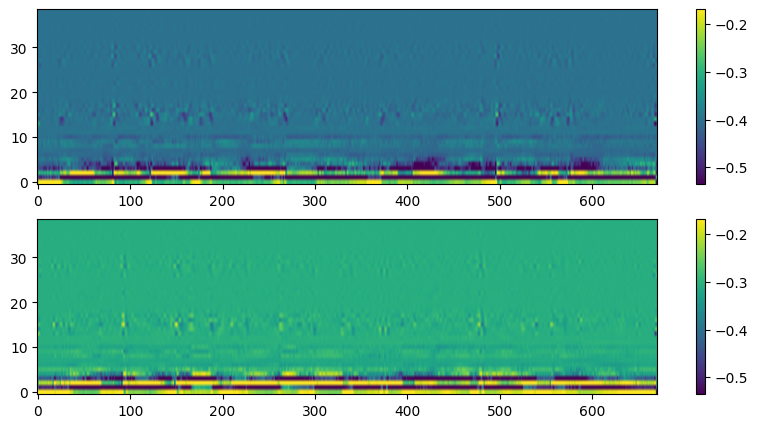

In [12]:
import matplotlib.pyplot as plt

def plot(images, cmap='viridis'):
    if images is None:
        print('Nothing to show.')
        return
    n = len(images)
    if n == 0:
        return
    fig, axs = plt.subplots(n, 1, figsize=(10,5))
    for idx in range(n):
        cax = axs[idx].imshow(images[idx], aspect='auto', origin='lower', cmap=cmap)
        fig.colorbar(cax, ax=axs[idx])
    plt.show()

plot(MFCC_bt, 'viridis')

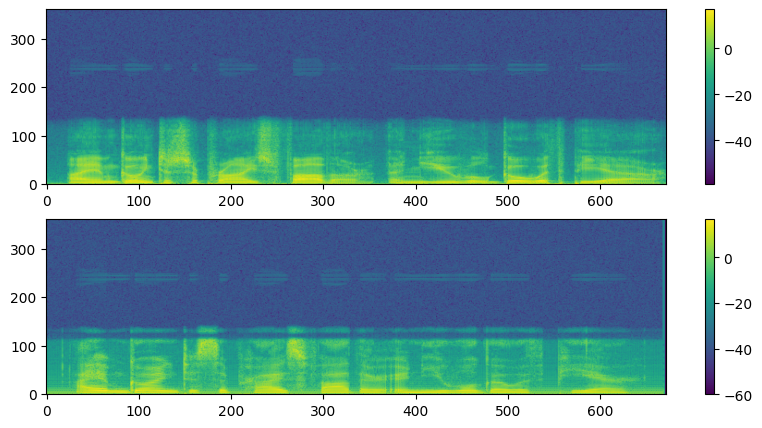

In [13]:
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

X_ft = Spectrogram(X_t)

A_ft   = torch.abs(X_ft)
phi_ft = torch.angle(X_ft)

PdB_ft = 10 * torch.log10(A_ft + 1e-6)
plot(PdB_ft)

In [14]:
import pandas as pd
from itertools import combinations

class CompositeScaler(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.ab_subsampling_map = self.generate_ab_subsampling_map()
    
    def forward(self, X_ft, scale, a=True):
        scale = round(scale, 2)
        if scale < 0.01 or 0.99 < scale:
            raise ValueError(f'`scale` MUST ALWAYS be a positive value whose range is [0.01, 0.99].')
        if scale in self.ab_subsampling_map.index:
            if not a:
                X_ft = torch.flipud(X_ft)
            scaled_X_ft = self.subsample_ab(X_ft, *self.ab_subsampling_map.loc[scale])
            if not a:
                X_ft = torch.flipud(X_ft)
                scaled_X_ft = torch.flipud(scaled_X_ft)
            if scaled_X_ft.shape[-1] > 0.10 * X_ft.shape[-1]:
                return scaled_X_ft
        return None
    
    @staticmethod
    def generate_ab_subsampling_map():
    
        records = []
        for stride in range(2, 101):
            records.append(__class__.generate_ab_subsampling_record(stride, True))
            records.append(__class__.generate_ab_subsampling_record(stride, False))
            
        df = pd.DataFrame.from_records(records)
        df = df.sort_values('deviation').groupby(['approx_ratio', 'complement_value']).head(1)
        df = df.drop_duplicates('approx_ratio').sort_values('approx_ratio').reset_index(drop=True)
        df.drop(['approx_ratio', 'deviation'], axis=1, inplace=True)
        
        records = df.to_dict(orient='records')
        pair_records = [
            [x for record in record_pair for x in record.values()] \
            for record_pair in combinations(records, 2)
        ]
        records = [list(record.values()) + [1, True, 1.0] for record in records]
        pair_records = records + pair_records
        
        columns = [f'{col}_{x}' for x in 'ab' for col in df.columns]
        df = pd.DataFrame(pair_records, columns=columns)
        
        df['ratio'] = df['ratio_a'] / df['ratio_b']
        
        df['approx_ratio'] = df['ratio'].round(2)
        df = df.sort_values(['ratio_a', 'ratio_b'], ascending=False).groupby('approx_ratio').head(1)
        df = df.drop_duplicates('approx_ratio').sort_values('approx_ratio')
        df.drop(['ratio'], axis=1, inplace=True)
        mask = (df['approx_ratio'] < 0.005) | (df['approx_ratio'] > 0.995)
        df = df[~mask].reset_index(drop=True)
        
        df['scale_factor_a'] = df['approx_ratio'].copy()
        gt_mask_a = df['ratio_a'] > df['ratio_b']
        df.loc[gt_mask_a, 'scale_factor_a'] = round(1 / df.loc[gt_mask_a, 'approx_ratio'], 2)
        
        df['scale_factor_b'] = df['approx_ratio'].copy()
        gt_mask_b = df['ratio_b'] > df['ratio_a']
        df.loc[gt_mask_b, 'scale_factor_b'] = round(1 / df.loc[gt_mask_b, 'approx_ratio'], 2)
        
        df.drop(['ratio_a', 'ratio_b', 'approx_ratio'], axis=1, inplace=True)
        
        assert all(df['scale_factor_a'] < df['scale_factor_b']), 'Scale A should be normalized to always result in shrinking A [0.01 to 0.99] (i.e. Stretching B)'
        
        df.drop('scale_factor_b', axis=1, inplace=True)
        df.set_index('scale_factor_a', inplace=True)

        return df
    
    @staticmethod
    def generate_ab_subsampling_record(stride:int, complement_value:bool):
        ratio = 1 / stride
        if not complement_value:
            ratio = 1 - ratio
        approx_ratio = round(ratio, 2)
        return {
            'stride': stride,
            'complement_value': complement_value,
            'ratio': ratio,
            'approx_ratio': approx_ratio,
            'deviation': abs(ratio - approx_ratio),
        }
    
    @staticmethod
    def subsample_ab(X_ft, stride_a, complement_value_a, stride_b, complement_value_b):
        if X_ft.shape[0] != 2 or X_ft.ndim != 3:
            raise ValueError(f'`X_ft` MUST ALWAYS be a 3D tensor with its first dimension being of size 2.')

        f_bins, t_bins = X_ft.shape[1:]
        
        masks = torch.stack([
            __class__.make_subsampling_mask(f_bins, t_bins, complement_value_a, stride_a), 
            __class__.make_subsampling_mask(f_bins, t_bins, complement_value_b, stride_b),
        ])
        
        t_lengths = masks[:,0,:].sum(-1)
        t_pads    = torch.max(t_lengths) - t_lengths
        
        scaled_X_ft = torch.stack([
            F.pad(
                X_ft[idx, masks[idx]].reshape([f_bins, t_lengths[idx]]),
                pad   = (0, t_pads[idx]),
                value = X_ft[idx].min()
            ) for idx in range(2)
        ])
    
        return scaled_X_ft
    
    @staticmethod
    def make_subsampling_mask(f_bins, t_bins, complement_value, stride):
        blank_tensor = torch.zeros if complement_value else torch.ones
        mask = blank_tensor(f_bins, t_bins, dtype=bool)
        mask[:, ::stride] = bool(complement_value)
        return mask
        
    def transformed_indices(self, i, j, scale, a):
        return self.indices(True, i, j, scale, a)
        
    def original_indices(self, i, j, scale, a):
        return self.indices(False, i, j, scale, a)
        
    def indices(self, fwd, i, j, scale, a):
        record = self.ab_subsampling_record(scale, a)
        if fwd:
            return self.transformed_index(i, *record[:2]), self.transformed_index(j, *record[2:])
        return self.original_index(i, *record[:2]), self.original_index(j, *record[2:])
        
    def ab_subsampling_record(self, scale, a):
        scale = round(scale, 2)
        record = self.ab_subsampling_map.loc[scale].tolist()
        if not a:
            record[:2], record[2:] = record[2:], record[:2]
        return record
    
    @staticmethod
    def original_index(idx, stride, complement_value):
        if complement_value:
            if stride == 1:
                return idx
            return (idx + 1) * stride - 1
        return idx // (stride - 1) * stride + idx % (stride - 1)

    @staticmethod
    def transformed_index(idx, stride, complement_value):
        if complement_value:
            if stride == 1:
                return idx
            return (idx + 1) // stride - 1
        return idx // stride * (stride - 1) + idx % stride

-------------------------------------- Scaling A --------------------------------------


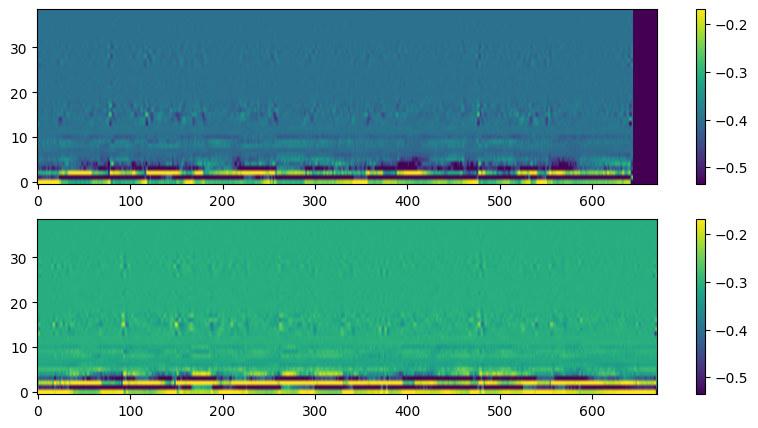



-------------------------------------- Scaling B --------------------------------------


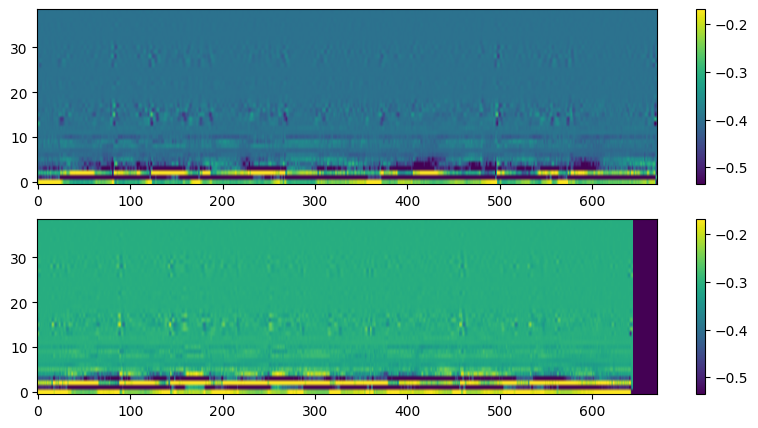

In [15]:
scaler = CompositeScaler()

print('-' * 38 + ' Scaling A ' + '-' * 38)
scaled_MFCC_bt = scaler(MFCC_bt, 0.96, a=True)
plot(scaled_MFCC_bt)
print('\n')
print('-' * 38 + ' Scaling B ' + '-' * 38)
scaled_MFCC_bt = scaler(MFCC_bt, 0.96, a=False)
plot(scaled_MFCC_bt)

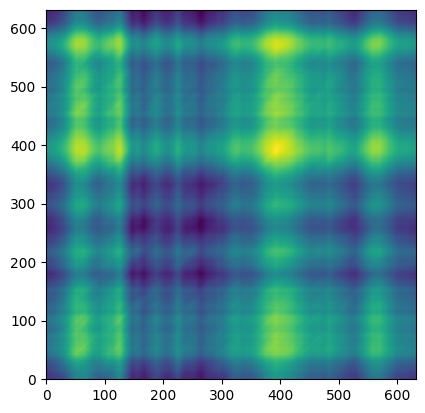

In [16]:
import torch.nn.functional as F

def pair_segmentation(MFCC_bt, t_kernel, t_stride, flattened=True):
    if MFCC_bt.shape[0] != 2 or MFCC_bt.ndim != 3:
        raise ValueError('`MFCC_bt` MUST be a pair of 2D tensors.')
    f_bins, t_bins = MFCC_bt.shape[1:]
    AB = F.unfold(
        MFCC_bt.unsqueeze(1), 
        kernel_size = (f_bins, t_kernel), 
        stride = (f_bins, t_stride),
    ).transpose(1,2)
    if not flattened:
        AB = AB.view(2, -1, f_bins, t_kernel)
    return tuple(AB)

def cosine_similarity(MFCC_bt, t_kernel, t_stride):
    A, B = pair_segmentation(MFCC_bt, t_kernel, t_stride)
    S = A @ B.T / (torch.linalg.norm(A) * torch.linalg.norm(B))
    return S

similarity_matrix = cosine_similarity(MFCC_bt, t_kernel=40, t_stride=1)
plt.imshow(similarity_matrix, origin='lower')
plt.show()

In [136]:
t_bins = similarity_matrix.shape[0]
i_indices = torch.arange(t_bins).unsqueeze(-1).expand(-1, t_bins).flatten().numpy()
j_indices = torch.arange(t_bins).unsqueeze(0).expand(t_bins, -1).flatten().numpy()
s_values = similarity_matrix.flatten().numpy()
tmp_df = pd.DataFrame(zip(i_indices, j_indices, s_values), columns=['i', 'j', 'similarity'])
tmp_df

,i,j,similarity
0,0,0,0.001546
1,0,1,0.001546
2,0,2,0.001546
3,0,3,0.001546
4,0,4,0.001546
...,...,...,...
399419,631,627,0.001544
399420,631,628,0.001545
399421,631,629,0.001545
399422,631,630,0.001547


In [137]:
tmp_df.insert(0, 'h', 1)
tmp_df

,h,i,j,similarity
0,1,0,0,0.001546
1,1,0,1,0.001546
2,1,0,2,0.001546
3,1,0,3,0.001546
4,1,0,4,0.001546
...,...,...,...,...
399419,1,631,627,0.001544
399420,1,631,628,0.001545
399421,1,631,629,0.001545
399422,1,631,630,0.001547


In [84]:
import numpy as np

def similarity_records(scale, a, t_kernel, similarity_matrix):
    t_bins = similarity_matrix.shape[0]
    i_indices = torch.arange(t_bins).unsqueeze(-1).expand(-1, t_bins).flatten().numpy()
    j_indices = torch.arange(t_bins).unsqueeze(0).expand(t_bins, -1).flatten().numpy()
    s_values = similarity_matrix.flatten().numpy()
    tmp_df = pd.DataFrame(zip(i_indices, j_indices, s_values), columns=['i', 'j', 'similarity'])
    tmp_df.insert(0, 't_kernel', t_kernel)
    tmp_df.insert(0, 'a', a)
    tmp_df.insert(0, 'scale', round(scale, 2))
    return tmp_df

def matching_frames(MFCC_bt, scale_range, t_kernel_range, t_stride=1):
    scaler, all_records = CompositeScaler(), None
    for t_kernel in t_kernel_range:
        for scale in scale_range:
            for a in range(2):
                
                scaled_MFCC_bt = scaler(MFCC_bt, scale, a)                
                if (scaled_MFCC_bt is None) or (t_kernel >= scaled_MFCC_bt.shape[-1]):
                    continue
                
                similarity_matrix = cosine_similarity(scaled_MFCC_bt, t_kernel, t_stride)
                records = similarity_records(scale, a, t_kernel, similarity_matrix)
                i, j, scale = map(lambda k: record[k], ['i','j','scale'])
                
                original_ij = scaler.original_indices(i+t_kernel, j+t_kernel, scale, a)
                if all(map(lambda x: x < MFCC_bt.shape[-1], original_ij)):
                    records.append(record)
                
    df  = pd.DataFrame.from_records(records)
    if df.size:
        df.insert(df.columns.tolist().index('similarity'), 'delta', abs(df['i'] - df['j']))
        df = df.sort_values(by=['similarity', 'delta', 'scale'], ascending=[False, True, False])
    
    return df


SCALE_RANGE    = np.arange(0.10, 1.00, 0.01)
T_KERNEL_RANGE = np.arange(10, 100, 1)

matching_records = matching_frames(MFCC_bt, SCALE_RANGE, T_KERNEL_RANGE)
matching_records.head()

""


In [80]:
t_bins = MFCC_bt.shape[-1]
t_bins

671

In [83]:
(matching_records.apply(lambda row: pd.Series(scaler.original_indices(row['i']+row['t_kernel'], row['j']+row['t_kernel'], row['scale'], row['a']), index=['i','j']), axis=1) < t_bins).all(1).mean()

np.float64(0.0)

In [61]:
['j'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  64,  65,  62,  63,
        66,  68,  69,  70,  76,  96,  77,  97,  67,  71,  73,  75,  78,
        79, 109, 114, 107, 108, 110, 117, 126, 127, 128, 129, 130, 112,
       113, 116, 118, 119, 120, 121, 122, 123, 124, 125, 192, 194, 193,
       195, 131, 132, 336, 224, 447, 559, 558, 503, 575, 574, 573, 572,
       571, 536, 284, 570, 569, 568, 567, 587, 566, 586, 565, 585, 302,
       596, 584, 283, 303, 583, 595, 582, 603, 594, 581, 580, 602, 593,
       610, 579, 592, 578, 601, 577, 591, 609, 600, 576, 619, 590, 608,
       599, 623, 589, 618, 588, 598, 607, 631, 597, 622, 606, 617, 637,
       605, 621, 616, 644, 630, 604, 285, 304, 280, 650, 615, 62

In [52]:
matching_records.shape

(14976, 7)

In [50]:
best_record = matching_records.to_dict(orient='records')[0]
best_record

IndexError: list index out of range

In [46]:
all(map(lambda xt: print(x, t), *zip([1,2], [3,4])))

1 2


False

In [43]:
*zip([1,2], [3,4])

SyntaxError: can't use starred expression here (3878949538.py, line 1)

In [ ]:
A, B = pair_segmentation(MFCC_bt,
                         t_kernel = best_record['t_kernel'],
                         t_stride = 1,
                         flattened = False)

best_match = torch.stack([
    A[best_record['i']],
    B[best_record['j']],
])

print('-' * 38 + ' Best Match ' + '-' * 38)
plot(best_match)

In [ ]:
raise Exception('Stop here')

In [ ]:
metadata, dataset, _ = zip(*map(get_audio_attrs, cmu))

In [ ]:
dataset = tuple(map(apply_vad, dataset))

In [ ]:
audio_groups = get_audio_groups(metadata, dataset)
pairs = get_matching_pairs(metadata, dataset, audio_groups)

In [ ]:
i, j = display_random_pair(dataset, pairs)

# i, j = [???, ???]
# display_pair(dataset, i, j)

In [ ]:
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

WIN_MS, HOP_MS   = 15, 5
WIN_LEN, HOP_LEN = map(lambda time_ms: time_ms * SAMPLERATE // 1000, [WIN_MS, HOP_MS])

SCALE_RANGE      = np.arange(0.20, 1.00, 0.01)
T_KERNEL_RANGE   = np.arange(10, 100, 1)
T_STRIDE         = 1

X_t = pad_sequence([dataset[i], dataset[j]]).T

mfcc_transformer = MFCCTransformer(samplerate  = SAMPLERATE,
                                   n_mfcc      = 13,
                                   winlen      = WIN_LEN,
                                   hoplen      = HOP_LEN,
                                   alpha       = 0.97,
                                   L           = 55,
                                   N           = 2,
                                   dd          = True,
                                   rasta       = True,
                                   postprocess = True)

MFCC_bt = mfcc_transformer(X_t)
plot(MFCC_bt, 'viridis')
scaler = CompositeScaler()
matching_records = matching_frames(MFCC_bt, SCALE_RANGE, T_KERNEL_RANGE, T_STRIDE)
best_record = matching_records.iloc[0].to_dict()
print(best_record)

A, B = pair_segmentation(MFCC_bt, best_record['t_kernel'], T_STRIDE, flattened=False)
best_match = torch.stack([
    A[best_record['i']],
    B[best_record['j']],
])
print('-' * 38 + ' Best Match ' + '-' * 38)
plot(best_match)

In [ ]:
scale, a, t_kernel, i, j, _, _ = best_record.values()

In [ ]:
scaler.ab_subsampling_map.loc[scale]

In [ ]:
i

In [ ]:
original_i0, original_j0 = scaler.original_indices(i, j, scale, a)
original_i1, original_j1 = scaler.original_indices(i + t_kernel, j + t_kernel, scale, a)
island_a, island_b = slice(original_i0, original_i1), slice(original_j0, original_j1)
island_a, island_b

In [ ]:
X_ft = Spectrogram(X_t)

samples_a = InvSpectrogram(X_ft[0, :, island_a].unsqueeze(0))
audio_a = Audio(samples_a, rate=SAMPLERATE)
display(audio_a)

samples_b = InvSpectrogram(X_ft[1, :, island_b].unsqueeze(0))
audio_b = Audio(samples_b, rate=SAMPLERATE)
display(audio_b)

In [ ]:
X_ft[0, :, island_a].shape

In [ ]:
389/403

In [ ]:
raise Exception('Stop here')

In [ ]:
matching_records.iloc[0]

In [ ]:
n = 0
while n < matching_records.shape[0]:
    
    rejected_indices = []
    best_scale, best_a, best_t_kernel, best_offset_i, best_offset_j, _, _ = matching_records.iloc[n]
    best_offset_i, best_offset_j = scaler.original_indices(best_offset_i, best_offset_j, best_scale, best_a)
    best_end_i, best_end_j       = scaler.original_indices(best_offset_i + best_t_kernel, 
                                                           best_offset_j + best_t_kernel, 
                                                           best_scale, best_a)
    for m in range(n+1, matching_records.shape[0]):
        scale, a, t_kernel, offset_i, offset_j, _, _ = matching_records.iloc[m]
        offset_i, offset_j = scaler.original_indices(offset_i, offset_j, scale, a)
        end_i, end_j       = scaler.original_indices(offset_i + t_kernel, 
                                                     offset_j + t_kernel, 
                                                     scale, a)
        if best_offset_i <= offset_i <= best_end_i or \
           best_offset_j <= offset_j <= best_end_j or \
           best_offset_i <= end_i <= best_end_i or \
           best_offset_j <= end_j <= best_end_j:
            rejected_indices.append(m)

    matching_records.drop(rejected_indices, inplace=True)
    n += 1

len(matching_records), len(rejected_indices)

In [ ]:
raise Exception('Stop here')

In [ ]:
import torch.nn.functional as F

kernel = 40
stride = 1

f_bins, t_bins = MFCC_bt.shape[1:]
segments = F.unfold(
    PdB_ft.unsqueeze(1),
    kernel_size = (f_bins, kernel),
    stride = (f_bins, stride)
).transpose(2,1).reshape(2, -1, f_bins, kernel)
seg_A, seg_B = segments.flatten(2)
cross_corr   = (seg_A @ seg_B.T) / seg_A.shape[-1] ** 2
plt.imshow(cross_corr, origin='lower')

In [ ]:
import torch.nn.functional as F

F.unfold(PdB_ft.flatten(1), kernel_size=40, stride=10).shape

In [ ]:
import torch.nn.functional as F

time_bins = PdB_ft.shape[-1]
frame_bins = 40

PdB_ft = F.pad(PdB_ft, pad=(0, frame_bins - time_bins % frame_bins), value=PdB_ft.min())
PdB_ft.shape

In [ ]:
segments = torch.split(PdB_ft.unsqueeze(1), frame_bins, -1)
segments_A, segments_B = torch.concat(segments, 1).flatten(2)
segments_A.shape, segments_B.shape

In [ ]:
vector_bins = segments_A.shape[-1]
similarity  = (segments_A @ segments_B.T) / vector_bins ** 2
plt.imshow(similarity, origin='lower', cmap='viridis')

In [ ]:
h, w = similarity.shape


In [ ]:
raise Exception()

In [ ]:
import torch
import torch.nn.functional as F

pad = lambda samples: F.pad(samples, pad=(0, MAX_SAMPLES - len(samples)), value=samples.abs().min())
X_t = torch.stack([pad(dataset[idx]) for idx in (i, j)])
original_samples = max(dataset[idx].numel() for idx in (i, j))
X_t.shape

In [ ]:
X_ft = Spectrogram(X_t)
A_ft, phi_ft = map(lambda func: func(X_ft), [torch.abs, torch.angle])
X_ft = A_ft * torch.exp(1j * phi_ft)
X_t  = InvSpectrogram(X_ft)
display(Audio(X_t[0], rate=SAMPLERATE))
display(Audio(X_t[1], rate=SAMPLERATE))

In [ ]:
import matplotlib.pyplot as plt

PdB_ft = 10 * torch.log10(A_ft + 1e-6)
PdB_ft = PdB_ft.detach().clone().numpy()
_, axs = plt.subplots(2, 1, figsize=(10, 4))
axs[0].imshow(PdB_ft[0], origin='lower')
axs[1].imshow(PdB_ft[1], origin='lower')

In [ ]:
import numpy as np

mask = PdB_ft > PdB_ft.min((1,2)).reshape(-1,1,1)
mask[:,-1,:].sum(-1)

In [ ]:
frame = 
hop   
= HOP_MS * SAMPLERATE // 1000


In [ ]:
raise Exception('Stop here!')

In [ ]:
PdB_ft = 10 * torch.log10(A_ft + 1e-6)
images = PdB_ft.detach().clone().numpy()
_, axs = plt.subplots(2, 1, figsize=(10, 4))
axs[0].imshow(images[0], origin='lower')
axs[1].imshow(images[1], origin='lower')

In [ ]:
bin_images = images > 1
for idx in range(2):
    bin_images[idx] = closing(bin_images[idx], footprint=footprint_rectangle([5,5]))
    bin_images[idx] = opening(bin_images[idx], footprint=footprint_rectangle([5,5]))
    plt.imshow(bin_images[idx, :150, :750], origin='lower', cmap='gray')
    plt.show()

In [ ]:
import numpy as np

idx_mask = np.where(bin_images[:, 0])


In [ ]:
masks = bin_images[:, 0]
masks